In [76]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [174]:
import numpy as np


class DeepRVFL:
    """A deep RVFL classifier or regression.

    Attributes:
        n_nodes: An integer of enhancement node number.
        lam: A floating number of regularization parameter.
        w_random_vec_range: A list, [min, max], the range of generating random weights.
        b_random_vec_range: A list, [min, max], the range of generating random bias.
        random_weights: A Numpy array shape is [n_feature, n_nodes], weights of neuron.
        random_bias: A Numpy array shape is [n_nodes], bias of neuron.
        beta: A Numpy array shape is [n_feature + n_nodes, n_class], the projection matrix.
        activation: A string of activation name.
        n_layer: A integer, N=number of hidden layers.
        data_std: A list, store normalization parameters for each layer.
        data_mean: A list, store normalization parameters for each layer.
        same_feature: A bool, the true means all the features have same meaning and boundary for example: images.
        task_type: A string of ML task type, 'classification' or 'regression'.
    """
    def __init__(self, n_nodes, lam, w_random_vec_range, b_random_vec_range, activation, n_layer, same_feature=False,
                 task_type='classification'):
        assert task_type in ['classification', 'regression'], 'task_type should be "classification" or "regression".'
        self.n_nodes = n_nodes
        self.lam = lam
        self.w_random_range = w_random_vec_range
        self.b_random_range = b_random_vec_range
        self.random_weights = []
        self.random_bias = []
        self.beta = None
        a = Activation()
        self.activation_function = getattr(a, activation)
        self.n_layer = n_layer
        self.data_std = [None] * self.n_layer
        self.data_mean = [None] * self.n_layer
        self.same_feature = same_feature
        self.task_type = task_type

    def train(self, data, label, n_class):
        """

        :param data: Training data.
        :param label: Training label.
        :param n_class: An integer of number of class. In regression, this parameter won't be used.
        :return: No return
        """

        assert len(data.shape) > 1, 'Data shape should be [n, dim].'
        assert len(data) == len(label), 'Label number does not match data number.'
        assert len(label.shape) == 1, 'Label should be 1-D array.'

        n_sample = len(data)
        n_feature = len(data[0])
        d = self.standardize(data, 0)  # Normalization data
        h = data.copy()
        for i in range(self.n_layer):
            h = self.standardize(h, i)  # Normalization data
            self.random_weights.append(self.get_random_vectors(len(h[0]), self.n_nodes, self.w_random_range))
            self.random_bias.append(self.get_random_vectors(1, self.n_nodes, self.b_random_range))
            h = self.activation_function(np.dot(h, self.random_weights[i]) + np.dot(np.ones([n_sample, 1]),
                                                                                    self.random_bias[i]))
            d = np.concatenate([h, d], axis=1)

        d = np.concatenate([d, np.ones_like(d[:, 0:1])], axis=1)
        if self.task_type == 'classification':
            y = self.one_hot(label, n_class)
        else:
            y = label
        if n_sample > (self.n_nodes * self.n_layer + n_feature):
            self.beta = np.linalg.inv((self.lam * np.identity(d.shape[1]) + np.dot(d.T, d))).dot(d.T).dot(y)
        else:
            self.beta = d.T.dot(np.linalg.inv(self.lam * np.identity(n_sample) + np.dot(d, d.T))).dot(y)

    def predict(self, data):
        """

        :param data: Predict data.
        :return: When classification, return Prediction result and probability.
                 When regression, return the output of rvfl.
        """
        n_sample = len(data)
        d = self.standardize(data, 0)
        h = data.copy()
        for i in range(self.n_layer):
            h = self.standardize(h, i)
            h = self.activation_function(np.dot(h, self.random_weights[i]) + np.dot(np.ones([n_sample, 1]),
                                                                                    self.random_bias[i]))
            d = np.concatenate([h, d], axis=1)
        d = np.concatenate([d, np.ones_like(d[:, 0:1])], axis=1)
        output = np.dot(d, self.beta)
        if self.task_type == 'classification':
            proba = self.softmax(output)
            result = np.argmax(proba, axis=1)
            return result, proba
        elif self.task_type == 'regression':
            return output

    def eval(self, data, label):
        """

        :param data: Evaluation data.
        :param label: Evaluation label.
        :return: When classification return accuracy.
                 When regression return MAE.
        """

        assert len(data.shape) > 1, 'Data shape should be [n, dim].'
        assert len(data) == len(label), 'Label number does not match data number.'
        assert len(label.shape) == 1, 'Label should be 1-D array.'

        n_sample = len(data)
        d = self.standardize(data, 0)
        h = data.copy()
        for i in range(self.n_layer):
            h = self.standardize(h, i)
            h = self.activation_function(np.dot(h, self.random_weights[i]) + np.dot(np.ones([n_sample, 1]),
                                                                                    self.random_bias[i]))
            d = np.concatenate([h, d], axis=1)
        d = np.concatenate([d, np.ones_like(d[:, 0:1])], axis=1)
        output = np.dot(d, self.beta)
        if self.task_type == 'classification':
            result = np.argmax(output, axis=1)
            acc = np.sum(np.equal(result, label)) / len(label)
            return acc
        elif self.task_type == 'regression':
            mae = np.mean(np.abs(output - label))
            return mae

    @staticmethod
    def get_random_vectors(m, n, scale_range):
        x = (scale_range[1] - scale_range[0]) * np.random.random([m, n]) + scale_range[0]
        return x

    @staticmethod
    def one_hot(x, n_class):
        y = np.zeros([len(x), n_class])
        for i in range(len(x)):
            y[i, x[i]] = 1
        return y

    def standardize(self, x, index):
        if self.same_feature is True:
            if self.data_std[index] is None:
                self.data_std[index] = np.maximum(np.std(x), 1/np.sqrt(len(x)))
            if self.data_mean[index] is None:
                self.data_mean[index] = np.mean(x)
            return (x - self.data_mean[index]) / self.data_std[index]
        else:
            if self.data_std[index] is None:
                self.data_std[index] = np.maximum(np.std(x, axis=0), 1/np.sqrt(len(x)))
            if self.data_mean[index] is None:
                self.data_mean[index] = np.mean(x, axis=0)
            return (x - self.data_mean[index]) / self.data_std[index]

    @staticmethod
    def softmax(x):
        return np.exp(x) / np.repeat((np.sum(np.exp(x), axis=1))[:, np.newaxis], len(x[0]), axis=1)


class Activation:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.e ** (-x))

    @staticmethod
    def sine(x):
        return np.sin(x)

    @staticmethod
    def hardlim(x):
        return (np.sign(x) + 1) / 2

    @staticmethod
    def tribas(x):
        return np.maximum(1 - np.abs(x), 0)

    @staticmethod
    def radbas(x):
        return np.exp(-(x**2))

    @staticmethod
    def sign(x):
        return np.sign(x)

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

In [186]:
num_nodes = 10  # Number of enhancement nodes.
regular_para = 0.001  # Regularization parameter.
weight_random_range = [-1, 1]  # Range of random weights.
bias_random_range = [0, 1]  # Range of random weights.
num_layer = 5  # Number of hidden layers
deep_rvfl = DeepRVFL(n_nodes=num_nodes, lam=regular_para, w_random_vec_range=weight_random_range,
                     b_random_vec_range=bias_random_range, activation='relu', n_layer=num_layer, same_feature=False,
                     task_type='regression')

In [187]:
# Load your stock price data
# Assuming your dataset has a 'Date' and 'Close' column
# Adjust this based on your actual dataset structure
df = pd.read_csv('apple_stocks_with_sentiment10.csv', parse_dates=['Date'])
data = df[['Close']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
y=data_scaled.copy()
y = y.reshape(-1)
lag = 10  # Adjust the lag as needed

# Create lagged sequences of y as input features
X = np.array([y[i:i+lag] for i in range(len(y)-lag)])

# Corresponding target variable (shifted by lag)
y = y[lag:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Train the model
deep_rvfl.train(X_train, y_train,0)

# Make predictions
predictions = deep_rvfl.predict(X_test)

# Inverse transform the predictions to the original scale
predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1))

# Inverse transform the y_test to the original scale for evaluation
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 2.96


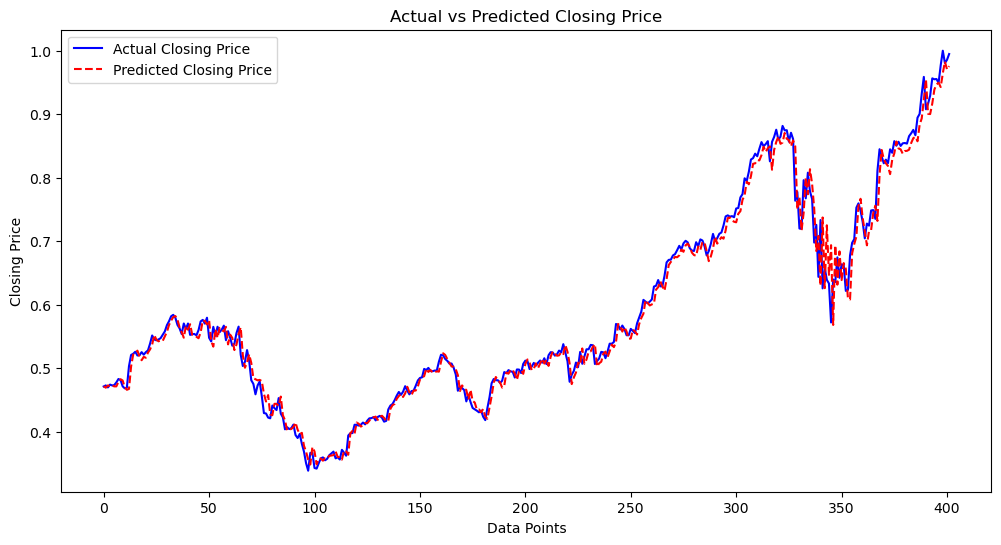

In [188]:
import matplotlib.pyplot as plt
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Closing Price', color='blue')
plt.plot(predictions, label='Predicted Closing Price', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Closing Price')
plt.xlabel('Data Points')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [189]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Relative Root Mean Squared Error (RRMSE)
rrmse = rmse / np.mean(y_test)

# Calculate Relative Mean Absolute Error (RMAE)
rmae = mean_absolute_error(y_test, predictions) / np.mean(y_test)

# Theil's U Statistic
theil_u = np.sqrt(np.mean((predictions - y_test) ** 2) / np.mean(y_test ** 2))

# Kling-Gupta Efficiency (KGE)
def kge(y_true, y_pred):
    std_true, std_pred = np.std(y_true), np.std(y_pred)
    mean_true, mean_pred = np.mean(y_true), np.mean(y_pred)
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    kge_value = 1 - np.sqrt((correlation - 1) ** 2 + (std_pred / std_true - 1) ** 2 + (mean_pred / mean_true - 1) ** 2)
    return kge_value

kge_value = kge(y_test, predictions)

# Absolute Percentage Bias (APB)
apb = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Legates metric
legates_metric = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((np.abs(predictions - np.mean(y_test)) + np.abs(y_test - np.mean(y_test))) ** 2))

# Nash-Sutcliffe Efficiency (NSE)
nse = 1 - np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

# Willmott's Index of Agreement (d)
d = 1 - (np.sum((np.abs(y_test - predictions)) ** 2) / np.sum((np.abs(predictions - np.mean(y_test)) + np.abs(y_test - np.mean(y_test))) ** 2))

# Standard Deviation of Error (SDE)
sde = np.std(y_test - predictions)

# Maximum Error
max_error = np.max(np.abs(y_test - predictions))

# Minimum Error
min_error = np.min(np.abs(y_test - predictions))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, predictions)

In [190]:
from io import StringIO
table = [
    ["Root Mean Squared Error (RMSE)", rmse],
    ["Mean Squared Error (MSE)", mse],
    ["Mean Absolute Error (MAE)", mae],
    ["Relative Root Mean Squared Error (RRMSE)", rrmse],
    ["Relative Mean Absolute Error (RMAE)", rmae],
    ["Theil\'s U Statistic (TU)", theil_u],
    ["Kling-Gupta Efficiency (KGE)", kge_value],
    ["Absolute Percentage Bias (APB)", apb],
    ["Legates metric (LM)", legates_metric],
    ["Nash-Sutcliffe Efficiency (NSE)", nse],
    ["Willmott's Index of Agreement (d)", d],
    ["Standard Deviation of Error (SDE)", sde],
    ["Legates metric", legates_metric],
    ["Nash-Sutcliffe Efficiency (NSE)", nse],
    ["Maximum Error (emax)", max_error],
    ["Minimum Error(emin)", min_error],
    ["Mean Absolute Error (MAE)", mae],
    ["R-squared (R2) Score", r2]
]
# Create a DataFrame
df = pd.DataFrame(table, columns=["Metric", "Value"])
df_metrics = df.round(3)
df_metrics

,Metric,Value
0,Root Mean Squared Error (RMSE),0.021
1,Mean Squared Error (MSE),0.000
2,Mean Absolute Error (MAE),0.013
3,Relative Root Mean Squared Error (RRMSE),0.035
4,Relative Mean Absolute Error (RMAE),0.023
5,Theil's U Statistic (TU),0.034
6,Kling-Gupta Efficiency (KGE),0.971
7,Absolute Percentage Bias (APB),2.216
8,Legates metric (LM),0.996
9,Nash-Sutcliffe Efficiency (NSE),0.983


In [191]:
from scipy.stats import t
actual_values=y_test
predicted_values=predictions
# Calculate the Mean Bias Error (MBE)
mbe = np.mean(predicted_values - actual_values)

# Calculate the standard deviation of the differences
std_diff = np.std(predicted_values - actual_values)

# Calculate the t-statistic
n = len(actual_values)
t_stat = mbe / (std_diff / np.sqrt(n))

# Degrees of freedom
df = n - 1

# Calculate the p-value
p_value = 2 * (1 - t.cdf(np.abs(t_stat), df))

# Display the t-statistic and p-value
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

T-Statistic: -3.1119149798289025
P-Value: 0.001991850104702708
Reject the null hypothesis
